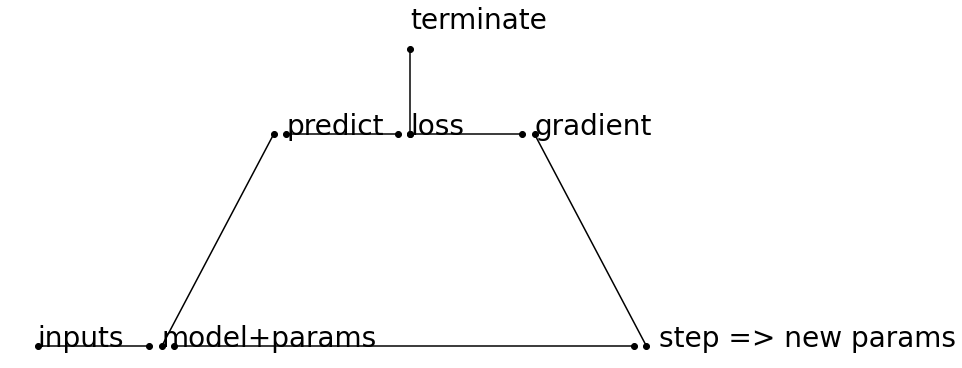

In [207]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns # seaborn does not really work with fastai...

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
make_chart()

### Using fastai

We shall now apply the exact same steps as taken above to separate handwritten digits 3 and 7. The inputs will be the pixel values, we employ touch larger network, loss function is updated for classification, but otherwise we take the same steps and apply the same principles.

First we need to load data:

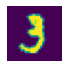

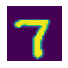

In [16]:
from fastai.vision.all import *
import torch.nn as nn
import matplotlib as mpl

path = untar_data(URLs.MNIST_SAMPLE)

# Load:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

# Put in lists:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

# Stack into tensors:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# Make a train set
X_train = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
y_train = tensor([1]*len(threes) + [0]*len(sevens)) #.unsqueeze(1)

# Finally combine the X and y into (X, y) tuples:
dset = list(zip(X_train, y_train))

#Make fastai dataloader:
dl = DataLoader(dset, batch_size=256)

# The whole above business for valid set:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255
X_valid = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28) 
y_valid = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)) #.unsqueeze(1)
valid_dset = list(zip(X_valid, y_valid))
valid_dl = DataLoader(valid_dset, batch_size=256)

# Dataloaders are provded by fastai and they ease the delivery of data to learners:
dls = DataLoaders(dl, valid_dl)

show_image(three_tensors[0]);
show_image(seven_tensors[0]);

#### Here we build a simple model using fastai and pytorch to learn and then predict in the above dsets:

In [17]:
lr = 1e-3

# Pytorch provides a linear model (this makes a simple neural net similar to before nnet_predict): 
simple_net = nn.Sequential(
    # First linear layer takes the input - the shape needs to match with the pixels from images (we flattened the images to 1D)
    nn.Linear(28*28, 30),
    # Use relu to bring non-linearity.
    nn.ReLU(),
    # The last layer takes the inputs from ReLU and spits out 2 numbers. One for 3 and one for 7
    nn.Linear(30, 2),
    # We do not do anything else here since the softmax is taken at the cross entropy.
)

# Learners can take care of the whole learning process. Convenient:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=accuracy)

# The you call the fit:
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.168036,1.741933,0.504416,00:00
1,0.127863,0.468935,0.809127,00:00
2,0.078064,0.246045,0.910697,00:00
3,0.055194,0.195322,0.932287,00:00
4,0.044621,0.167984,0.942100,00:00
5,0.039196,0.149657,0.951423,00:00
6,0.035981,0.136295,0.955839,00:00
7,0.033817,0.126107,0.957311,00:00
8,0.032182,0.118132,0.961727,00:00
9,0.030878,0.111517,0.965162,00:00


### Lets the do the full MNIST:

The whole business of loading data can be executed with .from_folder function

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0005754399462603033)

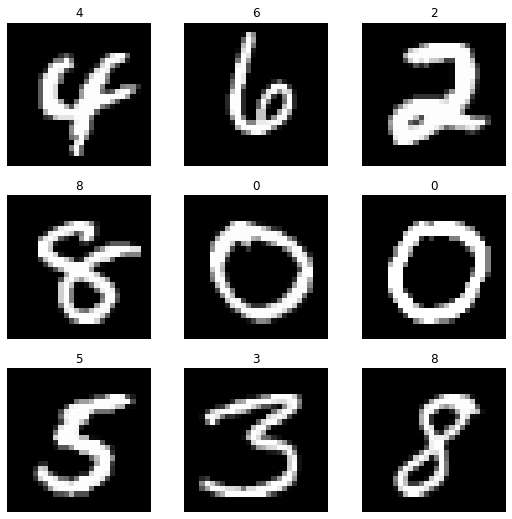

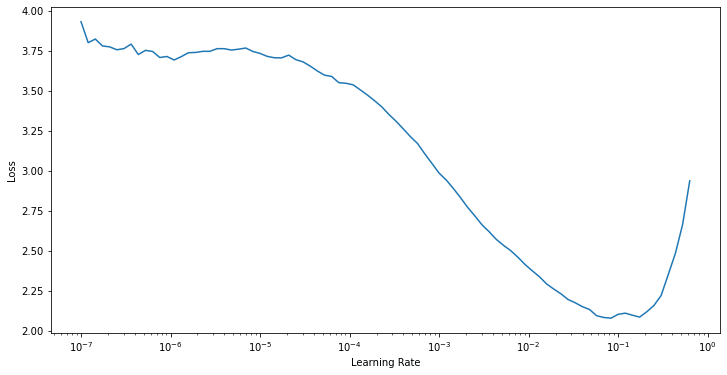

In [184]:
path = untar_data(URLs.MNIST)
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing') #, vocab=range(10))
dls.show_batch()
learn = cnn_learner(dls, resnet18, pretrained=False, metrics=accuracy, loss=F.cross_entropy) #loss=my_cross_e) #loss=F.nll_loss)
learn.lr_find()

In [198]:
#learn.fit_one_cycle(5, 0.005)
learn.fine_tune(10, .005) 

epoch,train_loss,valid_loss,accuracy,time
0,0.101444,0.095569,0.971300,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.095000,0.079585,0.974300,00:15
1,0.093954,0.085038,0.973500,00:15
2,0.089892,0.069720,0.979000,00:15
3,0.061571,0.065817,0.980400,00:15
4,0.042287,0.048677,0.985300,00:15
5,0.018544,0.041992,0.987800,00:15
6,0.012390,0.049583,0.988000,00:15
7,0.004595,0.044858,0.988800,00:15
8,0.003252,0.044076,0.989500,00:15
9,0.001250,0.043807,0.989600,00:15


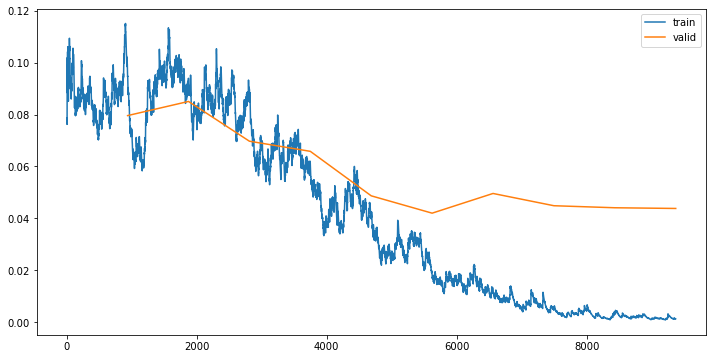

In [199]:
learn.recorder.plot_loss()

(<AxesSubplot:>, tensor(6), tensor(6, device='cuda:0'))

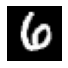

In [200]:
x,y = dls.one_batch()
preds,_ = learn.get_preds(dl=[(x,y)])
show_image(x[0]), F.softmax(preds[0], dim=0).argmax(), y[0]

In [201]:
interp = ClassificationInterpretation.from_learner(learn)

pred: 6 True: 5
pred: 2 True: 7
pred: 5 True: 9
pred: 7 True: 2
pred: 9 True: 4


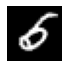

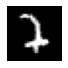

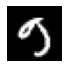

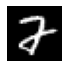

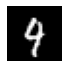

In [202]:
for idx in interp.top_losses()[1][:5]:
    print('pred: {} True: {}'.format(F.softmax(interp.preds[idx], dim=0).argmax(), interp.targs[idx]))
    show_image(interp.inputs[idx])

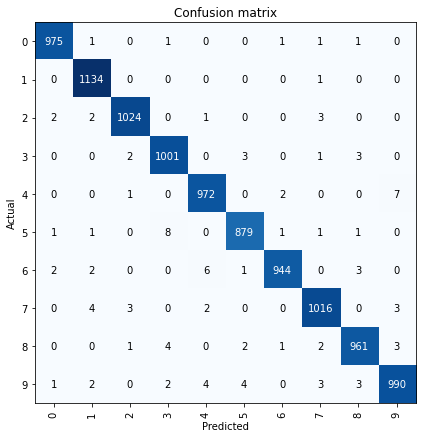

In [204]:
interp.plot_confusion_matrix() 

### About loss functions:

#### Likelihood: 
Consider instance training instance $\mathbf{x}_i$. $q_{i, c_i}$ is the probability given by the model for class $c_i$. Then the likelihood $\mathcal{L}$ of given outcome becomes:

$\mathcal{L} = \prod_{i} q_{i,c_i}$

The product can easily overflow or underflow or flow wherever (try typing such an thing into your Texas Ti-82!). We thus take logarhithm of the $\mathcal{L}$, and divide by $-N$, where N is the number of training instances, after all we are trying to maximize the likelihood and this can be done by minimizing the negative of its logarhithm. We call this quantity negative log-likelihood and use it, 

$l = -\frac{1}{N}\log \mathcal{L} = -\frac{1}{N} \log \left(\prod_{i} q_{i,c_i} \right) = -\frac{1}{N}\sum_{i} \log q_{i, c_i}$.

For the sake of seeing something familiar, say now that for given true label the model would always output the same $q_{c}$. Then we can reformulate the above sum ($n_c$ amount of class $c$ instances in training data),

$l = -\sum_c \frac{n_c}{N} \log q_c = - \sum_c p_c \log q_c$,

The lass term is called cross-entropy and it is one of the possible loss functions to pick for classification tasks. However, the formulation above holds *only* when the model is consisten in its outputs - better stick with the first formulation. 

Below we play a touch with the loss functions to make sure all is well:

In [174]:
def my_nll(preds, classes):
    """
    output the negative log_likelihood similar to F.nll_loss - NOTE!!! F.nll_loss
    expects that you provide ith with the logs of the class probabilities! This is weird (considering the function name),
    but it apparently has some computational reasons.
    """
    return -preds[range(len(preds)), classes].sum()/len(preds)

def my_cross_e(preds, classes):
    
    preds_log = torch.log_softmax(preds, dim=1)
    return my_nll(preds_log, classes)

N = 10
# These are outputs of a binary calssifier:
preds = torch.rand((N, 2))*6 - 3
# These are the true classes:
classes = torch.randint(0, 2, (len(preds), ))

# To check the output of softamx:
preds_prob = F.softmax(preds, dim=1) 

print(preds, preds_prob)

# To get the logs (and also softmaxing over the first dimension) we use
preds_log = F.log_softmax(preds, dim=1)

# Then when calling
my_nll(preds_log, classes), F.nll_loss(preds_log, classes), my_cross_e(preds, classes), F.cross_entropy(preds, classes)

tensor([[ 0.7672,  2.4931],
        [-1.4453,  2.8220],
        [-2.8205, -0.5760],
        [-1.8398, -2.7130],
        [-1.4855,  0.2546],
        [ 2.4240, -2.5364],
        [-2.5092, -0.3532],
        [ 2.5431,  1.8495],
        [-2.9564, -1.3039],
        [ 2.5044,  1.0264]]) tensor([[0.1511, 0.8489],
        [0.0138, 0.9862],
        [0.0958, 0.9042],
        [0.7054, 0.2946],
        [0.1493, 0.8507],
        [0.9930, 0.0070],
        [0.1038, 0.8962],
        [0.6668, 0.3332],
        [0.1608, 0.8392],
        [0.8143, 0.1857]])


(tensor(1.3148), tensor(1.3148), tensor(1.3148), tensor(1.3148))

### make chart

In [205]:
def make_chart():
    _, ax = plt.subplots()
    
    steps = \
    [[0, 0, 'inputs'],
     [1, 0, 'model+params'],
     [2, 1, 'predict'],
     [3, 1, 'loss'],
     [4, 1, 'gradient'],
     [5, 0, 'step => new params']
     ]
        
        
    def get_line(key):
        for s in steps:
            if s[2] == key: 
                return s
    fsize=28
    dx = .1
    for i, s in enumerate(steps):
        ax.text(*s, fontsize=fsize)
        if i>0: ax.plot([steps[i-1][0], steps[i][0] - dx], [steps[i-1][1], steps[i][1]], '-o', color='black')
    
    add_lines = [['step => new params', 'model+params'], ['loss', [0, .5, 'terminate']]]
    for aline in add_lines:
        s = get_line(aline[0]) 
        if isinstance(aline[1], str):
            s2 = get_line(aline[1]) 
            plt.plot([s[0]-2*dx, s2[0]+dx], [s[1], s2[1]], '-o', color='black') 
        else:
            x, y, text_ = aline[1]
            ax.text(x + s[0], y+s[1], text_, fontsize=fsize)
            plt.plot([s[0], s[0]+x], [s[1], s[1]+y-dx], '-o', color='black') 
    
    
    plt.axis('off')
